**NOTEBOOK 2: PROMPT ENGINEERING & DATA FORMATTING**

Task 3: Fine-tuning Phi-2 for Text Summarization with XSum
UAS Deep Learning - Final Term Assignment

This notebook:
1. Loads preprocessed XSum data from Google Drive
2. Designs effective prompts for Phi-2 (decoder-only LLM)
3. Formats data with instruction-style prompts
4. Tokenizes and prepares training-ready datasets
5. Saves formatted data for training notebook

**What This Notebook Accomplishes**
1. Loads your preprocessed data from Google Drive
2. Designs effective prompts - Tests 5 different templates and selects the optimal one for Phi-2
3. Formats the dataset - Applies prompts to all article-summary pairs
4. Tokenizes efficiently - Converts text to tokens with proper truncation
5. Analyzes token distributions - Ensures no unexpected issues
6. Creates two versions - Full dataset + smaller subset for fast experimentation
7. Saves everything to Drive - Ready for training notebook

**SETUP & LOAD PREPROCESSED DATA**

In [ ]:
print("="*70)
print("NOTEBOOK 2: PROMPT ENGINEERING & DATA FORMATTING")
print("="*70)

# Fix dependency conflicts first
print("\nResolving dependency conflicts...")
!pip install fsspec==2025.3.0 -q
!pip install 'datasets==3.1.0' transformers torch accelerate -q

import json
import torch
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM
from google.colab import drive
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

print("✓ Libraries imported successfully!")

NOTEBOOK 2: PROMPT ENGINEERING & DATA FORMATTING

Resolving dependency conflicts...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.1.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2025.3.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.9.0 which is incompatible.
✓ Libraries imported successfully!


In [ ]:
# Mount Google Drive
print("\n" + "="*70)
print("MOUNTING GOOGLE DRIVE")
print("="*70)
drive.mount('/content/drive')

# Define project directory
PROJECT_DIR = '/content/drive/MyDrive/DL_FinalTask_XSum'
print(f"✓ Project directory: {PROJECT_DIR}")

# Load preprocessed data
print("\n" + "="*70)
print("LOADING PREPROCESSED DATA")
print("="*70)

print("Loading cleaned XSum dataset...")
ds = load_from_disk(f'{PROJECT_DIR}/xsum_subset_dataset')

print(f"✓ Dataset loaded successfully!")
print(f"   Training samples: {len(ds['train']):,}")
print(f"   Validation samples: {len(ds['validation']):,}")
print(f"   Test samples: {len(ds['test']):,}")

# Load preprocessing metadata
with open(f'{PROJECT_DIR}/preprocessing_metadata.json', 'r') as f:
    preprocessing_config = json.load(f)

MAX_DOC_LENGTH = preprocessing_config['recommended_config']['max_doc_length']
MAX_SUM_LENGTH = preprocessing_config['recommended_config']['max_sum_length']

print(f"\n✓ Loaded configuration:")
print(f"   Max document length: {MAX_DOC_LENGTH} tokens")
print(f"   Max summary length: {MAX_SUM_LENGTH} tokens")



MOUNTING GOOGLE DRIVE
Mounted at /content/drive
✓ Project directory: /content/drive/MyDrive/DL_FinalTask_XSum

LOADING PREPROCESSED DATA
Loading cleaned XSum dataset...
✓ Dataset loaded successfully!
   Training samples: 10,000
   Validation samples: 1,000
   Test samples: 1,000

✓ Loaded configuration:
   Max document length: 1031 tokens
   Max summary length: 45 tokens


**LOAD PHI-2 TOKENIZER**

In [ ]:
print("\n" + "="*70)
print("LOADING PHI-2 TOKENIZER")
print("="*70)

print("Loading microsoft/phi-2 tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/phi-2",
    trust_remote_code=True
)

# Configure tokenizer
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"✓ Tokenizer loaded successfully!")
print(f"   Vocabulary size: {tokenizer.vocab_size:,}")
print(f"   Model max length: {tokenizer.model_max_length:,}")
print(f"   EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
print(f"   PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")


LOADING PHI-2 TOKENIZER
Loading microsoft/phi-2 tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

✓ Tokenizer loaded successfully!
   Vocabulary size: 50,257
   Model max length: 2,048
   EOS token: '<|endoftext|>' (ID: 50256)
   PAD token: '<|endoftext|>' (ID: 50256)


**PROMPT ENGINEERING EXPERIMENTS**

In [ ]:
print("\n" + "="*70)
print("PROMPT ENGINEERING FOR PHI-2")
print("="*70)

# Test different prompt templates
sample_article = ds['train'][0]['document']
sample_summary = ds['train'][0]['summary']

print("Sample article (first 200 chars):")
print(f"{sample_article[:200]}...\n")
print(f"Target summary: {sample_summary}\n")

print("="*70)
print("TESTING DIFFERENT PROMPT TEMPLATES")
print("="*70)

# Template 1: Simple instruction
template1 = f"""Summarize the following article in one sentence:

Article: {sample_article}

Summary:"""

# Template 2: Instruct-style (works well with Phi-2)
template2 = f"""Instruct: Summarize the following article concisely in one sentence.

Article: {sample_article}

Output:"""

# Template 3: Chat-style
template3 = f"""### Instruction:
Write a one-sentence summary of the article below.

### Article:
{sample_article}

### Summary:"""

# Template 4: Direct and concise (RECOMMENDED for Phi-2)
template4 = f"""Article: {sample_article}

Summarize the above article in one sentence.
Summary:"""

# Template 5: Question-answering style
template5 = f"""Question: What is the main point of this article?

Article: {sample_article}

Answer:"""

templates = {
    "Template 1 (Simple)": template1,
    "Template 2 (Instruct)": template2,
    "Template 3 (Chat)": template3,
    "Template 4 (Direct) ⭐": template4,
    "Template 5 (QA)": template5
}

print("\nPrompt Template Comparison:\n")
for name, template in templates.items():
    token_count = len(tokenizer.encode(template))
    print(f"{name}:")
    print(f"   Token count: {token_count}")
    print(f"   Preview: {template[:120]}...")
    print()


PROMPT ENGINEERING FOR PHI-2
Sample article (first 200 chars):
Richard Smith, 26, from Edinburgh, attacked the 30-year-old while she was asleep in a flat in Dalry following a night out on 2 August 2014.
The High Court in Glasgow heard how Smith was part of a grou...

Target summary: A man has been found guilty of raping a sleeping woman at a flat in Edinburgh.

TESTING DIFFERENT PROMPT TEMPLATES

Prompt Template Comparison:

Template 1 (Simple):
   Token count: 354
   Preview: Summarize the following article in one sentence:

Article: Richard Smith, 26, from Edinburgh, attacked the 30-year-old w...

Template 2 (Instruct):
   Token count: 358
   Preview: Instruct: Summarize the following article concisely in one sentence.

Article: Richard Smith, 26, from Edinburgh, attack...

Template 3 (Chat):
   Token count: 363
   Preview: ### Instruction:
Write a one-sentence summary of the article below.

### Article:
Richard Smith, 26, from Edinburgh, att...

Template 4 (Direct) ⭐:
   Token coun

**SELECT OPTIMAL PROMPT TEMPLATE**

In [ ]:
print("="*70)
print("SELECTED PROMPT TEMPLATE FOR TRAINING")
print("="*70)

# We'll use Template 4 (Direct) - it's clean, concise, and works well with Phi-2
PROMPT_TEMPLATE = """Article: {article}

Summarize the above article in one sentence.
Summary: {summary}"""

PROMPT_TEMPLATE_INFERENCE = """Article: {article}

Summarize the above article in one sentence.
Summary:"""

print("✓ Selected: Template 4 (Direct and Concise)")
print("\nRationale:")
print("  • Clear and straightforward instruction")
print("  • Minimal token overhead")
print("  • Works well with decoder-only models like Phi-2")
print("  • Explicit task specification")
print("\nTraining format:")
print(PROMPT_TEMPLATE)
print("\nInference format (no summary provided):")
print(PROMPT_TEMPLATE_INFERENCE)

SELECTED PROMPT TEMPLATE FOR TRAINING
✓ Selected: Template 4 (Direct and Concise)

Rationale:
  • Clear and straightforward instruction
  • Minimal token overhead
  • Works well with decoder-only models like Phi-2
  • Explicit task specification

Training format:
Article: {article}

Summarize the above article in one sentence.
Summary: {summary}

Inference format (no summary provided):
Article: {article}

Summarize the above article in one sentence.
Summary:


**FORMAT DATASET WITH PROMPTS**

In [ ]:
print("\n" + "="*70)
print("FORMATTING DATASET WITH PROMPTS")
print("="*70)

def format_prompt(example):
    """Format a single example with prompt template"""
    # Create the full prompt with article and summary
    prompt_with_summary = PROMPT_TEMPLATE.format(
        article=example['document'].strip(),
        summary=example['summary'].strip()
    )

    # Create prompt without summary (for inference testing later)
    prompt_without_summary = PROMPT_TEMPLATE_INFERENCE.format(
        article=example['document'].strip()
    )

    return {
        'text': prompt_with_summary,  # Full text for training
        'prompt': prompt_without_summary,  # Just prompt for inference
        'target_summary': example['summary'].strip(),  # Ground truth
        'original_document': example['document'].strip(),
        'id': example['id']
    }

print("Applying prompt template to all splits...")

# Format all splits
ds_formatted = ds.map(
    format_prompt,
    desc="Formatting prompts",
    remove_columns=['document', 'summary']  # Remove original columns
)

print(f"\n✓ Dataset formatted successfully!")
print(f"   Train samples: {len(ds_formatted['train']):,}")
print(f"   Val samples: {len(ds_formatted['validation']):,}")
print(f"   Test samples: {len(ds_formatted['test']):,}")

# Show examples
print("\n" + "="*70)
print("FORMATTED EXAMPLES")
print("="*70)

for i in range(2):
    example = ds_formatted['train'][i]
    print(f"\n--- Example {i+1} ---")
    print("FULL TEXT (for training):")
    print(example['text'][:300] + "...")
    print(f"\nTarget summary: {example['target_summary']}")
    print(f"Text length: {len(example['text'])} characters")
    print()


FORMATTING DATASET WITH PROMPTS
Applying prompt template to all splits...


Formatting prompts:   0%|          | 0/10000 [00:00<?, ? examples/s]

Formatting prompts:   0%|          | 0/1000 [00:00<?, ? examples/s]

Formatting prompts:   0%|          | 0/1000 [00:00<?, ? examples/s]


✓ Dataset formatted successfully!
   Train samples: 10,000
   Val samples: 1,000
   Test samples: 1,000

FORMATTED EXAMPLES

--- Example 1 ---
FULL TEXT (for training):
Article: Richard Smith, 26, from Edinburgh, attacked the 30-year-old while she was asleep in a flat in Dalry following a night out on 2 August 2014.
The High Court in Glasgow heard how Smith was part of a group that had returned to the flat after a night at Lulu club in Edinburgh.
The rapist worked ...

Target summary: A man has been found guilty of raping a sleeping woman at a flat in Edinburgh.
Text length: 1671 characters


--- Example 2 ---
FULL TEXT (for training):
Article: Today's hi-tech version bringing books to rural communities is a world away from the first ever mobile library in the UK.
It was a Ford van fitted with wooden shelves and holding between 800 and 900 books.
From 1921 it could be seen visiting towns and villages throughout Perthshire.
In 1924...

Target summary: The mobile library is now familiar

In [ ]:
print("="*70)
print("TOKENIZING DATASET FOR TRAINING")
print("="*70)

# Set max lengths with buffer for special tokens
MAX_LENGTH = MAX_DOC_LENGTH + MAX_SUM_LENGTH + 50  # Buffer for prompt overhead

print(f"Configuration:")
print(f"   Max total length: {MAX_LENGTH} tokens")
print(f"   Truncation: Enabled")
print(f"   Padding: Dynamic (will pad during training)")

def tokenize_function(examples):
    """Tokenize the formatted text"""
    # Tokenize the full text (article + prompt + summary)
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False,  # We'll pad dynamically during training
        return_tensors=None
    )

    # For causal LM, labels are the same as input_ids
    # The model will learn to predict the summary tokens
    tokenized['labels'] = tokenized['input_ids'].copy()

    return tokenized

print("\nTokenizing datasets...")

# Tokenize all splits
tokenized_datasets = ds_formatted.map(
    tokenize_function,
    batched=True,
    desc="Tokenizing",
    remove_columns=['text', 'prompt', 'original_document']  # Keep only target_summary for eval
)

print(f"\n✓ Tokenization complete!")
print(f"   Train samples: {len(tokenized_datasets['train']):,}")
print(f"   Val samples: {len(tokenized_datasets['validation']):,}")
print(f"   Test samples: {len(tokenized_datasets['test']):,}")

TOKENIZING DATASET FOR TRAINING
Configuration:
   Max total length: 1126 tokens
   Truncation: Enabled
   Padding: Dynamic (will pad during training)

Tokenizing datasets...


Tokenizing:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1000 [00:00<?, ? examples/s]


✓ Tokenization complete!
   Train samples: 10,000
   Val samples: 1,000
   Test samples: 1,000


**ANALYZE TOKENIZED DATA**


ANALYZING TOKENIZED SEQUENCES


Analyzing token lengths:   0%|          | 0/1000 [00:00<?, ?it/s]


📊 Token Length Statistics:
   Mean: 483.9 tokens
   Median: 424.5 tokens
   Min: 94 tokens
   Max: 1126 tokens
   P95: 1070.3 tokens
   P99: 1126.0 tokens

⚠️  Sequences at max length (truncated): 43 (4.30%)


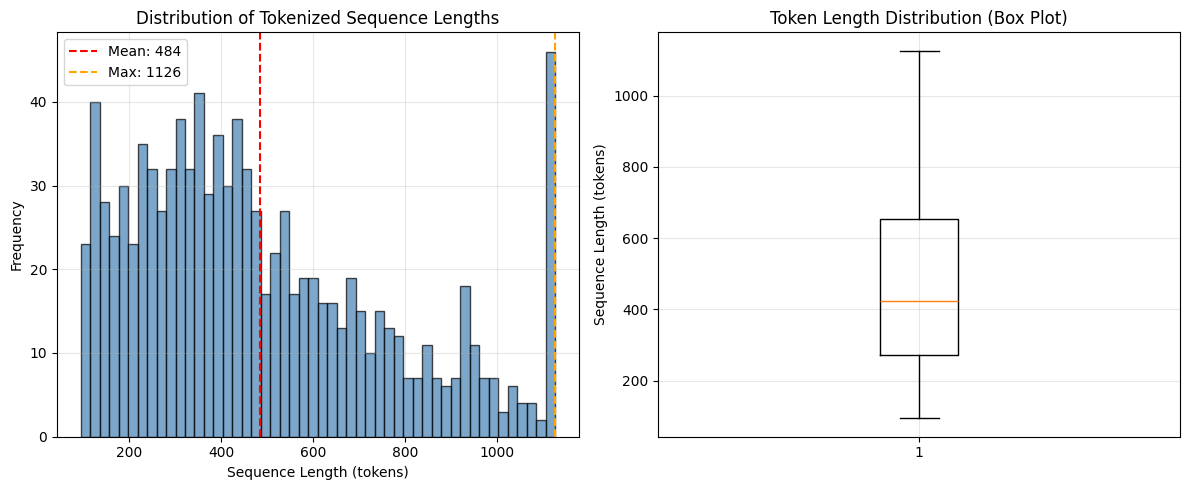

✓ Plot saved as 'tokenized_sequence_lengths.png'


In [ ]:
print("\n" + "="*70)
print("ANALYZING TOKENIZED SEQUENCES")
print("="*70)

# Sample and analyze token lengths
sample_size = min(1000, len(tokenized_datasets['train']))
sample_indices = np.random.choice(len(tokenized_datasets['train']), sample_size, replace=False)

token_lengths = []
for idx in tqdm(sample_indices, desc="Analyzing token lengths"):
    token_lengths.append(len(tokenized_datasets['train'][int(idx)]['input_ids']))

print(f"\n📊 Token Length Statistics:")
print(f"   Mean: {np.mean(token_lengths):.1f} tokens")
print(f"   Median: {np.median(token_lengths):.1f} tokens")
print(f"   Min: {np.min(token_lengths)} tokens")
print(f"   Max: {np.max(token_lengths)} tokens")
print(f"   P95: {np.percentile(token_lengths, 95):.1f} tokens")
print(f"   P99: {np.percentile(token_lengths, 99):.1f} tokens")

# Check if any sequences were truncated
truncated = sum(1 for l in token_lengths if l >= MAX_LENGTH)
print(f"\n⚠️  Sequences at max length (truncated): {truncated} ({truncated/len(token_lengths)*100:.2f}%)")

# Plot distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(token_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Tokenized Sequence Lengths')
plt.axvline(np.mean(token_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(token_lengths):.0f}')
plt.axvline(MAX_LENGTH, color='orange', linestyle='--', label=f'Max: {MAX_LENGTH}')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(token_lengths, vert=True)
plt.ylabel('Sequence Length (tokens)')
plt.title('Token Length Distribution (Box Plot)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('tokenized_sequence_lengths.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved as 'tokenized_sequence_lengths.png'")

**VERIFY DATA QUALITY**

In [ ]:
print("\n" + "="*70)
print("VERIFYING TOKENIZED DATA QUALITY")
print("="*70)

# Check a few examples to ensure proper formatting
print("\nSpot-checking tokenized examples:\n")

for i in range(3):
    example = tokenized_datasets['train'][i]

    # Decode the tokens back to text
    decoded_text = tokenizer.decode(example['input_ids'])

    print(f"--- Example {i+1} ---")
    print(f"Token count: {len(example['input_ids'])}")
    print(f"Decoded text preview:\n{decoded_text[:400]}...")
    print(f"Target summary: {example['target_summary']}")
    print()

# Verify labels match input_ids
print("Verifying labels...")
sample = tokenized_datasets['train'][0]
labels_match = all(sample['input_ids'][i] == sample['labels'][i]
                   for i in range(len(sample['input_ids'])))
print(f"✓ Labels match input_ids: {labels_match}")


VERIFYING TOKENIZED DATA QUALITY

Spot-checking tokenized examples:

--- Example 1 ---
Token count: 370
Decoded text preview:
Article: Richard Smith, 26, from Edinburgh, attacked the 30-year-old while she was asleep in a flat in Dalry following a night out on 2 August 2014.
The High Court in Glasgow heard how Smith was part of a group that had returned to the flat after a night at Lulu club in Edinburgh.
The rapist worked there at the time as a barman. Judge Lord McEwan deferred sentencing until 16 March in Edinburgh.
Fi...
Target summary: A man has been found guilty of raping a sleeping woman at a flat in Edinburgh.

--- Example 2 ---
Token count: 559
Decoded text preview:
Article: Today's hi-tech version bringing books to rural communities is a world away from the first ever mobile library in the UK.
It was a Ford van fitted with wooden shelves and holding between 800 and 900 books.
From 1921 it could be seen visiting towns and villages throughout Perthshire.
In 1924, Kent became th

**CREATE SMALLER TRAINING SUBSET (OPTIONAL)**

In [ ]:
print("\n" + "="*70)
print("CREATING SMALLER SUBSET FOR FAST EXPERIMENTATION")
print("="*70)

# Create even smaller subset for quick training tests
train_small = tokenized_datasets['train'].shuffle(seed=42).select(range(2000))
val_small = tokenized_datasets['validation'].shuffle(seed=42).select(range(500))

print(f"✓ Created fast-training subset:")
print(f"   Training: {len(train_small):,} samples")
print(f"   Validation: {len(val_small):,} samples")
print(f"\nUse this for initial experiments before full training!")


CREATING SMALLER SUBSET FOR FAST EXPERIMENTATION
✓ Created fast-training subset:
   Training: 2,000 samples
   Validation: 500 samples

Use this for initial experiments before full training!


**SAVE FORMATTED DATASETS**

In [ ]:
print("\n" + "="*70)
print("SAVING FORMATTED DATASETS TO GOOGLE DRIVE")
print("="*70)

# Save full tokenized dataset
print("Saving full tokenized dataset...")
tokenized_datasets.save_to_disk(f'{PROJECT_DIR}/xsum_tokenized_full')
print(f"✓ Saved to: {PROJECT_DIR}/xsum_tokenized_full")

# Save smaller subset
from datasets import DatasetDict
small_dataset = DatasetDict({
    'train': train_small,
    'validation': val_small
})
small_dataset.save_to_disk(f'{PROJECT_DIR}/xsum_tokenized_small')
print(f"✓ Saved small subset to: {PROJECT_DIR}/xsum_tokenized_small")

# Save formatting configuration
formatting_config = {
    'prompt_template_training': PROMPT_TEMPLATE,
    'prompt_template_inference': PROMPT_TEMPLATE_INFERENCE,
    'max_length': MAX_LENGTH,
    'tokenizer': 'microsoft/phi-2',
    'statistics': {
        'mean_token_length': float(np.mean(token_lengths)),
        'median_token_length': float(np.median(token_lengths)),
        'p95_token_length': float(np.percentile(token_lengths, 95)),
        'p99_token_length': float(np.percentile(token_lengths, 99)),
        'truncated_percentage': float(truncated/len(token_lengths)*100)
    }
}

with open(f'{PROJECT_DIR}/formatting_config.json', 'w') as f:
    json.dump(formatting_config, f, indent=2)
print(f"✓ Saved configuration to: {PROJECT_DIR}/formatting_config.json")

# Copy visualization to Drive
import shutil
shutil.copy('tokenized_sequence_lengths.png',
            f'{PROJECT_DIR}/tokenized_sequence_lengths.png')
print(f"✓ Saved plot to Drive")

print("\n" + "="*70)
print("✅ DATA FORMATTING COMPLETE!")
print("="*70)

print("\n📋 Summary:")
print(f"   1. Loaded preprocessed XSum data from Drive")
print(f"   2. Designed optimal prompt template for Phi-2")
print(f"   3. Formatted {len(ds_formatted['train']):,} training samples")
print(f"   4. Tokenized all splits with max_length={MAX_LENGTH}")
print(f"   5. Average sequence length: {np.mean(token_lengths):.0f} tokens")
print(f"   6. Saved tokenized datasets to Drive")

print("\n📁 Files created:")
print(f"   • {PROJECT_DIR}/xsum_tokenized_full/")
print(f"   • {PROJECT_DIR}/xsum_tokenized_small/")
print(f"   • {PROJECT_DIR}/formatting_config.json")
print(f"   • {PROJECT_DIR}/tokenized_sequence_lengths.png")

print("\n🚀 Next Steps:")
print("   → Proceed to Notebook 3: Model Fine-tuning with LoRA/QLoRA")
print("   → Use 'xsum_tokenized_small' for quick experiments")
print("   → Use 'xsum_tokenized_full' for final training")


SAVING FORMATTED DATASETS TO GOOGLE DRIVE
Saving full tokenized dataset...


Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

✓ Saved to: /content/drive/MyDrive/DL_FinalTask_XSum/xsum_tokenized_full


Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

✓ Saved small subset to: /content/drive/MyDrive/DL_FinalTask_XSum/xsum_tokenized_small
✓ Saved configuration to: /content/drive/MyDrive/DL_FinalTask_XSum/formatting_config.json
✓ Saved plot to Drive

✅ DATA FORMATTING COMPLETE!

📋 Summary:
   1. Loaded preprocessed XSum data from Drive
   2. Designed optimal prompt template for Phi-2
   3. Formatted 10,000 training samples
   4. Tokenized all splits with max_length=1126
   5. Average sequence length: 484 tokens
   6. Saved tokenized datasets to Drive

📁 Files created:
   • /content/drive/MyDrive/DL_FinalTask_XSum/xsum_tokenized_full/
   • /content/drive/MyDrive/DL_FinalTask_XSum/xsum_tokenized_small/
   • /content/drive/MyDrive/DL_FinalTask_XSum/formatting_config.json
   • /content/drive/MyDrive/DL_FinalTask_XSum/tokenized_sequence_lengths.png

🚀 Next Steps:
   → Proceed to Notebook 3: Model Fine-tuning with LoRA/QLoRA
   → Use 'xsum_tokenized_small' for quick experiments
   → Use 'xsum_tokenized_full' for final training
